In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

#import lsst.ip.diffim as ipDiffim
# I linked from ip_diffim/python/lsst/ip/diffim/imageMapReduce.py into diffimTests/imageMapReduce.py
#    (or copy it)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import diffimTests as dit
#reload(dit)

testObj = dit.DiffimTest(#varFlux2=np.repeat(2000, 20), 
                         varFlux2=np.repeat(620*np.sqrt(2), 20),
                         n_sources=600, verbose=True, sourceFluxRange=(2000., 120000.), 
                         psf_yvary_factor=0.5, psfSize=13)
res = testObj.runTest(spatialKernelOrder=2)
print res

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: -0.492813481453 0.493450410102
Variable source: 11 481.504254729 446.769330925 0 876.812408671
Variable source: 6 60.2485291279 35.3191743182 0 876.812408671
Variable source: 19 441.050733817 436.806559587 0 876.812408671
Variable source: 20 446.291646029 86.4683838602 0 876.812408671
Variable source: 1 66.5809759253 424.38486369 0 876.812408671
Variable source: 12 466.843050607 342.354052063 0 876.812408671
Variable source: 17 45.6530981449 331.260325215 0 876.812408671
Variable source: 10 302.643969883 44.7418294743 0 876.812408671
Variable source: 0 368.142255845 436.045411845 0 876.812408671
Variable source: 13 146.056622889 434.017042329 0 876.812408671
Variable source: 5 396.07140698 121.296576813 0 876.812408671
Variable source: 21 245.245586804 439.913841214 0 876.812408671
Variable source: 24 129.950748293 390.033308509 0 876.812408671
Variable source: 4 431.66

In [28]:
import lsst.afw.geom as afwGeom

exposure = testObj.im2.asAfwExposure()
template = testObj.im1.asAfwExposure()

exposure.setPsf(testObj.variablePsf.getCoaddPsf(exposure))
exposure.getPsf().computeKernelImage(afwGeom.Point2D(28., 66.)).getDimensions()

Extent2I(27, 25)

A&L(dec): stats(mean=0.067814469, stdev=24.66267, min=-163.18324, max=254.4686)
Zogy: stats(mean=0.012979774, stdev=24.89982, min=-766.09802, max=920.05609)
A&L(dec) - Zogy: stats(mean=0.0084713195, stdev=2.7234917, min=-507.58203, max=752.74695)
A&L(dec) - A&L: stats(mean=-0.027041059, stdev=6.8375096, min=-46.375702, max=70.128235)
Scorr: stats(mean=3.5062346e-06, stdev=0.0002689925, min=-0.014587875, max=0.013802416)
Scorr_var: stats(mean=0.00025200401, stdev=1.4755125e-06, min=0.0002467602, max=0.0012738681)


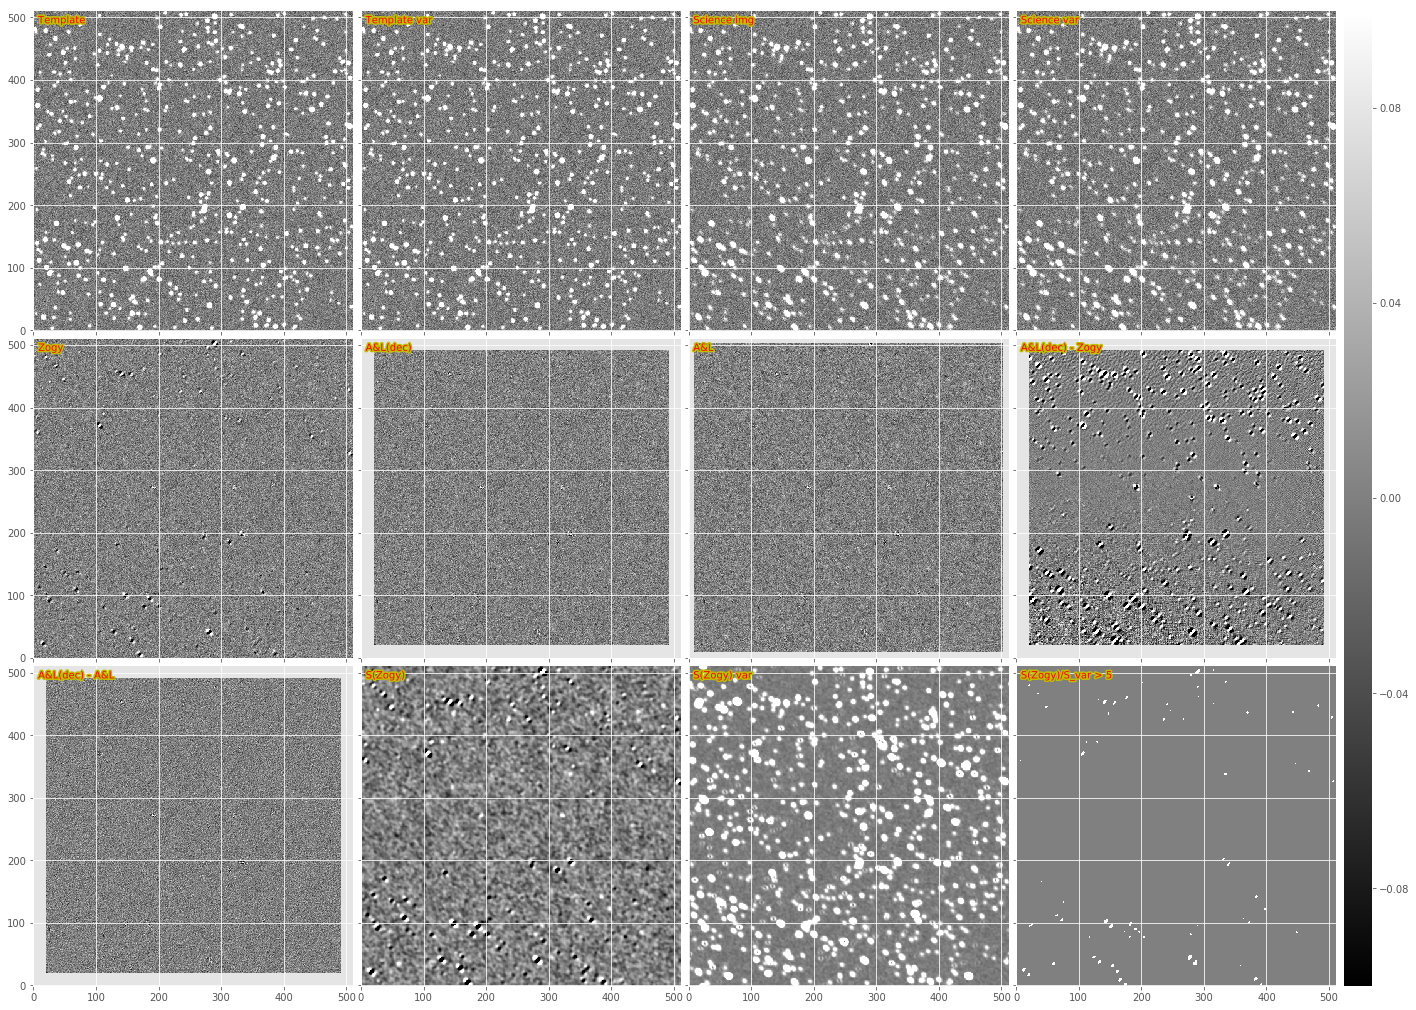

In [29]:
#dit.plotImageGrid((testObj.im1.im, testObj.im2.im), imScale=8)
testObj.doPlot(imScale=6, include_Szogy=True);

In [30]:
import lsst.pex.config as pexConfig
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.pipe.base as pipeBase
import lsst.ip.diffim as ipDiffim

In [31]:
config = dit.ALdecMapReduceConfig()
#config.gridStepX = config.gridStepY = 5
#config.gridSizeX = config.gridSizeY = 7
config.borderSizeX = config.borderSizeY = 3
config.reducerSubtask.reduceOperation = 'average'
task = dit.ImageMapReduceTask(config=config)
print config
#boxes0, boxes1 = task._generateGrid(exposure)

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


In [32]:
def ga(exposure):
    return exposure.getMaskedImage().getImage().getArray()
def gv(exposure):
    return exposure.getMaskedImage().getVariance().getArray()

In [33]:
import testPsfexPsfEDITED as tpp

exposure2 = testObj.im2.asAfwExposure()
#res = dit.tasks.doMeasurePsf(exposure2) #, psfMeasureConfig=config)
#psf = res.psf
obj = tpp.SpatialModelPsfTestCase() # removed superclass unittest.TestCase
obj.setExposure(exposure2)
obj.setUp()
obj.testPsfexDeterminer()
psf = obj.exposure.getPsf()
exposure2.setPsf(psf)

template2 = testObj.im1.asAfwExposure()
#res = dit.tasks.doMeasurePsf(template2) #, psfMeasureConfig=config)
#psf = res.psf
obj = tpp.SpatialModelPsfTestCase() # removed superclass unittest.TestCase
obj.setExposure(template2)
obj.setUp()
obj.testPsfexDeterminer()
psf = obj.exposure.getPsf()
template2.setPsf(psf)

530
536


In [34]:
ALres = dit.tasks.doAlInStack(template2, exposure2, doWarping=False, doDecorr=True, doPreConv=False,
            spatialBackgroundOrder=0, spatialKernelOrder=2)

In [35]:
newExpC = task.run(ALres.subtractedExposure, template=template2, science=exposure2,
                  alTaskResult=ALres, forceEvenSized=True).exposure

In [36]:
testObj2 = testObj.clone()
testObj2.ALres.decorrelatedDiffim = newExpC
testObj2.runTest(spatialKernelOrder=2)

{'ALstack': {'FN': 5, 'FP': 3, 'TP': 15},
 'ALstack_decorr': {'FN': 12, 'FP': 3, 'TP': 8},
 'SZogy': {'FN': 13, 'FP': 34, 'TP': 7},
 'Zogy': {'FN': 12, 'FP': 40, 'TP': 8}}

Finally, let's compare it to spatially-varying ZOGY!

In [37]:
config = dit.ZogyMapReduceConfig()
config.gridStepX = config.gridStepY = 9
#config.gridSizeX = config.gridSizeY = 10
config.borderSizeX = config.borderSizeY = 3
config.reducerSubtask.reduceOperation = 'average'
task = dit.ImageMapReduceTask(config=config)
print config

newExpZ = task.run(exposure2, template=template2, inImageSpace=False,
                       Scorr=False, forceEvenSized=True).exposure
newExpZ_Scorr = task.run(exposure2, template=template2, inImageSpace=False,
                       Scorr=True, forceEvenSized=True).exposure

{'gridStepY': 9.0, 'gridStepX': 9.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


In [38]:
testObj3 = testObj.clone()
testObj3.ALres.decorrelatedDiffim = newExpC
testObj3.D_Zogy = newExpZ  #dit.Exposure(ga(newExpZ), testObj.D_Zogy.psf, gv(newExpZ))
testObj3.S_Zogy = newExpZ_Scorr  #dit.Exposure(ga(newExpZ_Scorr), dit.psf.afwPsfToArray(newExpZ_Scorr.getPsf()), gv(newExpZ_Scorr))
testObj3.runTest(spatialKernelOrder=2)

{'ALstack': {'FN': 5, 'FP': 3, 'TP': 15},
 'ALstack_decorr': {'FN': 12, 'FP': 3, 'TP': 8},
 'SZogy': {'FN': 8, 'FP': 3, 'TP': 12},
 'Zogy': {'FN': 7, 'FP': 1, 'TP': 13}}

In [39]:
testObj3.doPlot(imScale=8, include_Szogy=True, centroidCoord=[424,66]

SyntaxError: unexpected EOF while parsing (<ipython-input-39-6cd8c593a4a2>, line 1)

In [ ]:
def gp(exp, coord):
    return exp.getPsf().computeImage(afwGeom.Point2D(coord[0], coord[1])).getArray()
    
dit.plotImageGrid((gp(exposure2, [80,80]), gp(newExpC, [80,80]), gp(newExpZ, [80,80]),
                   gp(exposure2, [255,255]), gp(newExpC, [255,255]), gp(newExpZ, [255,255]),
                   gp(exposure2, [480,480]), gp(newExpC, [480,480]), gp(newExpZ, [480,480]),), 
                  clim=(-0.0005, 0.001), nrows_ncols=(3, 3))